# <h1><center><font color=red>Data Mining</font></center></h1>
<h1><center><font color=red>Sentiment Analysis</font></center></h1>


Read tweets and lexica data.

# <font color=blue>Acquiring Data</font>

Use pandas library to read from files

In [1]:
from pandas import DataFrame, read_csv

Read the train2017.tsv file and create the training data frame. 

In [22]:
location="../twitter_data/train2017.tsv"
tr_df=read_csv(location,sep='\t+',names=["Tweet Id","User Id","Sentiment","Text"],engine="python")


Read the test2017.tsv file and create the test data frame. 

In [23]:
location="../twitter_data/test2017.tsv"
ts_df=read_csv(location,sep='\t+',names=["Tweet Id","User Id","Sentiment","Text"],engine="python")

Read the SemEval2017_task4_subtaskA_test_english_gold.txt file and create the golden labels data frame.

In [24]:
location="../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt"
glab_df=read_csv(location,sep='\t+',names=["Tweet Id","Sentiment"],engine="python")

Read the affin.txt file and create the affin lexicon data frame.

In [25]:
location="../lexica/affin/affin.txt"
aflex_df=read_csv(location,sep='\t+',names=["Word","Value"],engine="python",keep_default_na=False)

Read the valence_tweet.txt file and create the valence_tweet lexicon data frame.

In [26]:
location="../lexica/emotweet/valence_tweet.txt"
vtlex_df=read_csv(location,sep='\t+',names=["Word","Value"],engine="python",keep_default_na=False)

Read the generic.txt file and create the generic lexicon data frame.

In [27]:
location="../lexica/generic/generic.txt"
genlex_df=read_csv(location,sep='\t+',names=["Word","Value"],engine="python",keep_default_na=False)

Read the nrc/val.txt file and create the nrc_val lexicon data frame.

In [28]:
location="../lexica/nrc/val.txt"
nrclex_df=read_csv(location,sep='\t+',names=["Word","Value"],engine="python",keep_default_na=False)

Read the nrctag/val.txt file and create the nrctag_val lexicon data frame.

In [29]:
location="../lexica/nrctag/val.txt"
nrctags_df=read_csv(location,sep='\t+',names=["Word","Value"],engine="python",keep_default_na=False)

From each lexicon data frame create a dictionary. <br>
The dictionary's key is the word. <br>
The dictionary's value is the normalized value [-1.0,1.0] of the word. 

In [30]:
def lex_dict(ldf):
    dictionary={}
    maximum=ldf["Value"].max()
    minimum=ldf["Value"].min()
    max_abs=abs(minimum)
    if maximum>max_abs:
        max_abs=maximum
    
    for row in ldf.itertuples(index=False):    
        text=row[0]
        value=float(row[1])/max_abs
        dictionary[text]=value
    
    return dictionary

aflex_dict=lex_dict(aflex_df)
vtlex_dict=lex_dict(vtlex_df)
genlex_dict=lex_dict(genlex_df)
nrclex_dict=lex_dict(nrclex_df)
nrctags_dict=lex_dict(nrctags_df)

# <font color=blue>Data Cleaning & Preprocessing </font>

In [31]:
from nltk.tokenize import TweetTokenizer
from re import sub
from string import punctuation
from nltk import pos_tag
from re import finditer
from nltk.stem import WordNetLemmatizer
tw=TweetTokenizer()
lemmatizer = WordNetLemmatizer()
dicts=[aflex_dict,vtlex_dict,genlex_dict,nrclex_dict,nrctags_dict]

Create a list of the most common emoticons (created by ascci characters, e.g. :) ) which are saved in the common_emo.txt

In [32]:
path="../common_emo.txt"
emo_file=open(path, "r").read()
emojis=emo_file.splitlines()

Create a stopword set containing the words in file lo_value_common_words.txt <br>
The stopwords were devised via the visualization of the most common words in all, positive, negative and neutral tweets.

In [33]:
paths=["../stopwords/lo_value_common_words.txt","../stopwords/first_names.txt"]
stop_words=set()
for path in paths:
    stopwords_file=open(path, "r").read()
    stop_words=stop_words.union(set(word.lower() for word in stopwords_file.splitlines()))

The __isNumber/1__ function is used by the isTime/1 function. <br>
It is also used by the text2tokens function to identify whether a token is a number. In that case the token is discarded

In [34]:
def isNumber(text):
    try:
        float(text)
        return True
    except ValueError:
        return False
    
#e.g.
#isNumber("30")
#isNumber("30.1")
#isNumber("3ad")

Compute the mean value of the tokens passed as argument(toks).
The values used are from the dictionary lex_dict(e.g. genlex_dict)

In [35]:
def tweet_mdicval(lex_dict,toks):
    found=0
    totalVal=0
    for t in toks:
        if t in lex_dict:
            found+=1
            totalVal+=lex_dict[t]
    if found>0:
        return totalVal/found
    else:
        return 0


#EXAMPLES



#print("demand:",aflex_dict["demand"])
#print("demand:",aflex_dict["applaud"])
#print(tweet_mdicval(aflex_dict,["demand","applaud"]))




#print("increasing:",genlex_dict["increasing"])
#print("compound in generic lexicon:","compound" in genlex_dict)
#print("interest:",genlex_dict["interest"])
#tweet_mdicval(genlex_dict,["increasing","compound","interest"])



Tokenize the tweet's text passed as argument. <br>
The function returns a list of tokens. <br>
If the sentence contains one of the most common emojis, the emoji is identified as a token.  <br>
Unicode sequences are transformed to the character (e.g. \u002c -> ,) <br> 
The mentions (e.g. @pinkysibbs) and so are the urls (e.g. http://www.theindychannel.com/news/15182722/detail.html) are deleted. <br>
After the sentence's emojis are found, the punctuation is discarded. <br>
The hashtags' starting character # (e.g. #nhllockout) is discarded. (e.g #nhllockout -> nhllockout). <br>
In order to interpretate our data:
>the number of nouns, verbs and adjectives of the sentences are counted (before removing the stopwords) <br>
>the length of the tweet (before removing the stopwords) <br>
>the average value of the tokens for each lexicon's dictionary (after removing the stopwords) <br>

In [36]:
def text2tokens(text):
    
    i=0
    for match in finditer("\\\\u", text):
        text=text[:match.start()-5*i]+text[match.start()-5*i:match.start()+6-5*i].encode('utf-8').decode('unicode_escape')+text[match.start()+6-5*i:]
        i+=1
        
    text=sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', text)
    text=sub(r'(\s)@\w+', '', text)

    toks=[]
    for em in emojis:
        if em in text:
            toks.append(em)
            
    text=text.translate(str.maketrans('', '', punctuation))
        
    
    tok_text=tw.tokenize(text)
    tweet_length=len(tok_text)
    
    nouns=0
    adjs=0
    vbs=0

    for results in pos_tag(tok_text):
        result=results[1]
        if(result[0]=="N"):
            nouns+=1
        elif(result[0]=="J"):
            adjs+=1
        elif(result[0]=="V"):
            vbs+=1

    
    for token in tok_text:
        ltoken=token.lower()
        if len(ltoken)>1 and ltoken not in stop_words:
            if not(isNumber(ltoken)):
                toks.append(ltoken)
    
    tweet_mvals=[]
    for dic in dicts:
        tweet_mvals.append(tweet_mdicval(dic,toks))
        
    return toks,nouns,adjs,vbs,tweet_length,tweet_mvals

#EXAMPLE

#text2tokens("@StevieVanZandt It's my 25th birthday tonight!! and i'm ready to rock at Roskilde Festival! Bring your A-game! :)")
#text2tokens("Please be advised that Round 51 of the Eastern Province Special Stage Rally Championship\u002c scheduled for the 8th of... http://t.co/DZHsZcUM")
#text2tokens("I'll go to the office 2h hour earlier and watch Federer's game tomorrow!")

Create tr_tweet_info dictionary. The dictionary includes information about the tweets of the training set. <br>
The dictionary's key is the tweet's id. <br>
The dictionary's value includes:
>the tweet's tokens after its data have been cleaned <br>
>the tweet's sentiment  <br>
>the tweet's nouns number <br>
>the tweet's adjectives number  <br> 
>the tweet's verbs number  <br>
>the tweet's length <br>
>a list of length 5 containing the tweet's tokens mean values based on the normalized values of the lexica aflex, vtlex, genlex, nrclex, nrctags respectively <br>

Some bookkeeping is done for statistical purposes that will be apparent in the data visualization

In [37]:
tr_tweet_info={}
Positive=[0,0,0]
Negative=[0,0,0]
Neutral=[0,0,0]
Numberofwords=[0,0,0]
positiveWords=[]
negativeWords=[]
neutralWords=[]
individs=[]
positiveTweets=0.0
negativeTweets=0.0
neutralTweets=0.0

for index,tweets in tr_df.iterrows():
    
    t_id=tweets["Tweet Id"]
    text=tweets["Text"]
    sent=tweets["Sentiment"]
    Listofwords,nouns,adjs,verbs,tweet_length,tweet_mvals=text2tokens(text)
    if t_id not in tr_tweet_info:
        tr_tweet_info[t_id]=(Listofwords,nouns,adjs,verbs,tweet_length,tweet_mvals,sent)
        individs.append(tr_tweet_info[t_id][6])
    
    if(tweets["Sentiment"]=="positive"):
        positiveWords+=Listofwords
        Positive[0]+=nouns
        Positive[1]+=adjs
        Positive[2]+=verbs
        Numberofwords[0]+=tweet_length
        positiveTweets+=1.0
    elif(tweets["Sentiment"]=="neutral"):
        neutralWords+=Listofwords
        Neutral[0]+=nouns
        Neutral[1]+=adjs
        Neutral[2]+=verbs
        Numberofwords[1]+=tweet_length
        neutralTweets+=1.0
    elif(tweets["Sentiment"]=="negative"):
        negativeWords+=Listofwords
        Negative[0]+=nouns
        Negative[1]+=adjs
        Negative[2]+=verbs    
        Numberofwords[2]+=tweet_length
        negativeTweets+=1.0
#tr_tweet_info

Create tst_tweet_info dictionary. The dictionary includes information about the tweets of the test set. <br>
The dictionary's key is the tweet's id. <br>
The dictionary's value includes:
>the tweet's tokens after its data have been cleaned <br>
>the tweet's nouns number <br>
>the tweet's adjectives number  <br> 
>the tweet's verbs number  <br>
>the tweet's length <br>
>a list of length 5 containing the tweet's tokens mean values based on the normalized values of the lexica aflex, vtlex, genlex, nrclex, nrctags respectively <br>

In [38]:
tst_tweet_info={}

for index,tweets in ts_df.iterrows():
    
    t_id=tweets["Tweet Id"]
    text=tweets["Text"]
    toks,nouns,adjs,vbs,tweet_length,tweet_mvals=text2tokens(text)
    
    tst_tweet_info[t_id]=(toks,nouns,adjs,vbs,tweet_length,tweet_mvals)

#tst_tweet_info

Analysis and Visualization of the trained data tweets

# <font color=blue>Data Analysis </font>

In [39]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

positive_text=" ".join(word for word in positiveWords)
negative_text=" ".join(word for word in negativeWords)
neutral_text=" ".join(word for word in neutralWords)
text=positive_text+" "+negative_text+" "+neutral_text

## <font color=Red> Most Common Words </font>

Create,display and save the wordcloud of words contained in all the tweets.

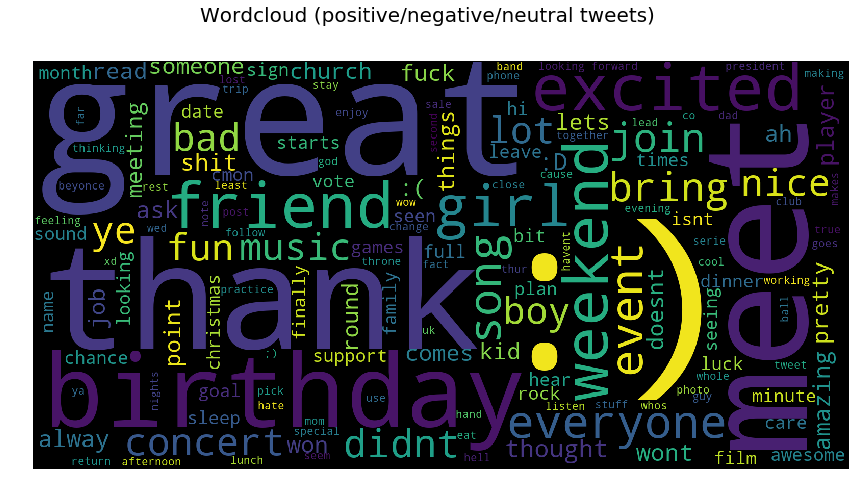

In [48]:
wordcloud = WordCloud(height=800, width=1600, max_words=150, background_color="black", regexp=r"[^\s]+").generate(text)# Display the generated image:
# the matplotlib way:
fig=plt.figure( figsize=(15,7.5) )
fig.suptitle("Wordcloud (positive/negative/neutral tweets)", fontsize=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight')

Find the most common words in the training set tweets and draw the corresponding bar plot.

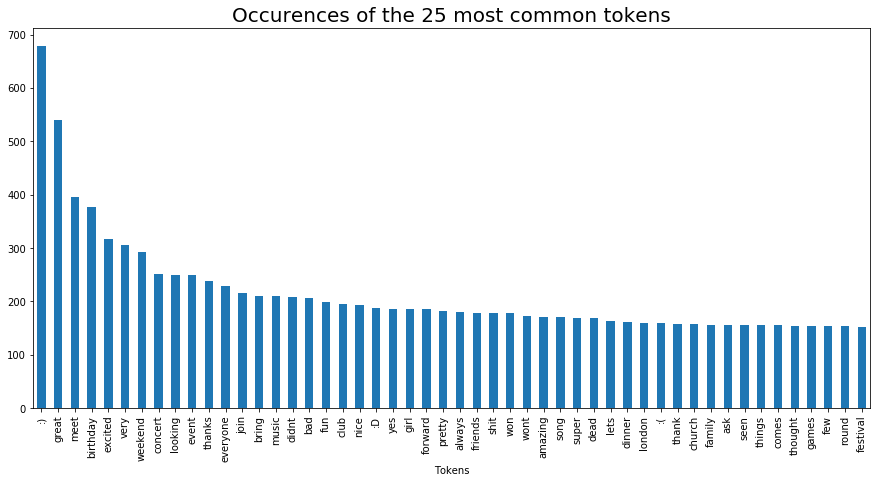

In [49]:
%matplotlib inline
from collections import Counter
from matplotlib import *  

filteredWord=[]
sent_words=[positiveWords,negativeWords,neutralWords]
for wordsList in sent_words:
    filteredWord+=wordsList
count=Counter(filteredWord)
cmWords_df= DataFrame(data = count.most_common(50), columns=['Tokens', 'Occurences']).set_index('Tokens')

plt.figure(figsize=(15,7))
graph=cmWords_df['Occurences'].plot.bar(x="Tokens",y="Occurences",title="Occurences of the 25 most common tokens")
graph.title.set_size(20)

## <font color=Red> Most Common Positive, Negative, Neutral Words </font>

Create,display and save the wordcloud of words contained in positive the tweets.

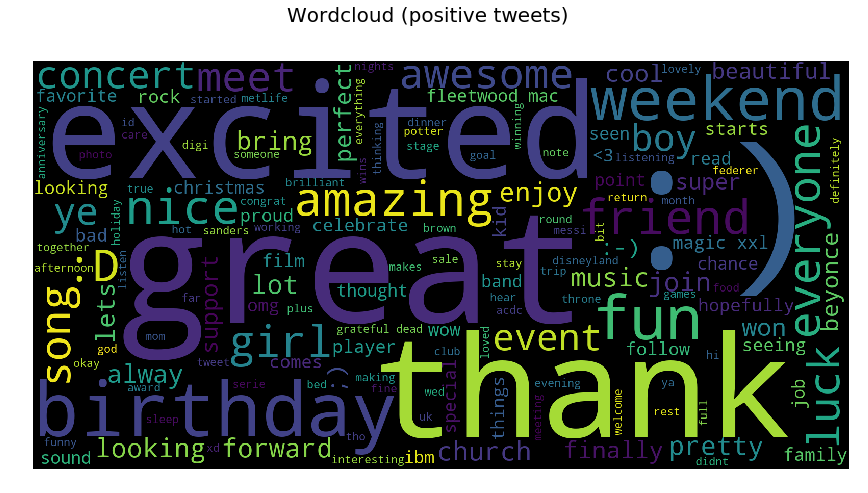

In [50]:
pos_wordcloud = WordCloud(height=800, width=1600, max_words=150, background_color="black", regexp=r"[^\s]+").generate(positive_text)# Display the generated image:
# the matplotlib way:

fig=plt.figure( figsize=(15,7.5) )
fig.suptitle("Wordcloud (positive tweets)", fontsize=20)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.savefig('positive_wordcloud.png', facecolor='k', bbox_inches='tight')

Create,display and save the wordcloud of words contained in negative the tweets.

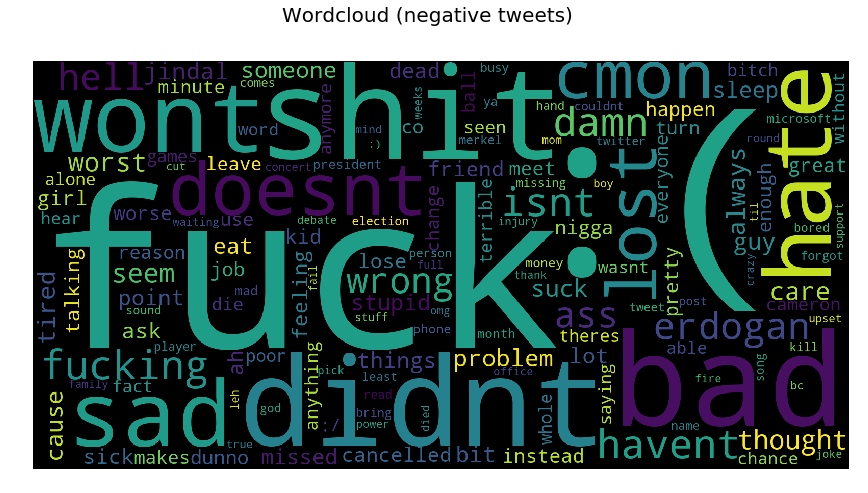

In [51]:
wordcloud = WordCloud(height=800, width=1600, max_words=150, background_color="black",regexp=r"[^\s]+").generate(negative_text)# Display the generated image:
# the matplotlib way:
fig=plt.figure( figsize=(15,7.5) )
fig.suptitle("Wordcloud (negative tweets)", fontsize=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('negative_wordcloud.png', facecolor='k', bbox_inches='tight')

Create,display and save the wordcloud of words contained in neutral the tweets.

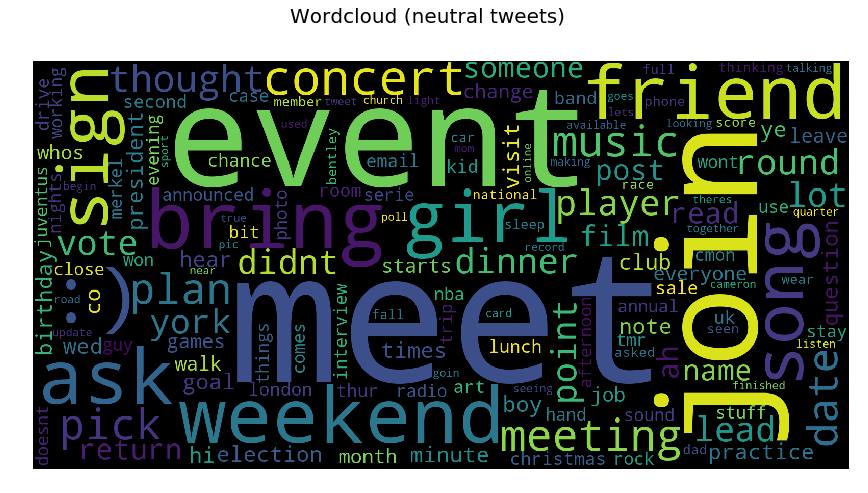

In [52]:
wordcloud = WordCloud(height=800, width=1600, max_words=150, background_color="black",regexp=r"[^\s]+").generate(neutral_text)# Display the generated image:
# the matplotlib way:
fig=plt.figure( figsize=(15,7.5) )
fig.suptitle("Wordcloud (neutral tweets)", fontsize=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('neutral_wordcloud.png', facecolor='k', bbox_inches='tight')

Find the most common words in the training set positive,neagtive and neutral tweets and draw the corresponding bar plots.

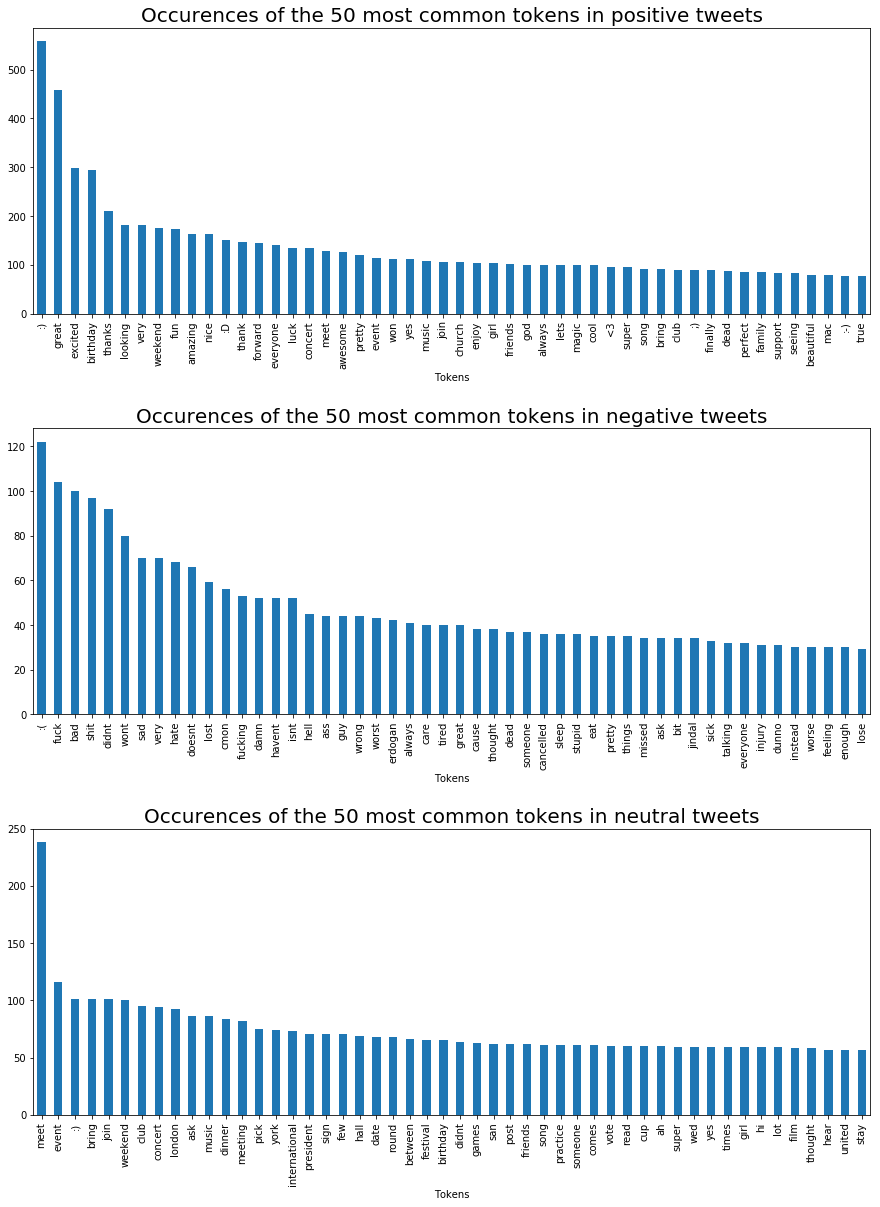

In [55]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(15,20))
fig.subplots_adjust(hspace=0.4)

sent_words=[positiveWords,negativeWords,neutralWords]
splt_pos=[axes[0],axes[1],axes[2]]
ttls=["Occurences of the 50 most common tokens in positive tweets","Occurences of the 50 most common tokens in negative tweets","Occurences of the 50 most common tokens in neutral tweets"]
for ind,filteredWord in enumerate(sent_words):
    count=Counter(filteredWord)
    cmWords_df= DataFrame(data = count.most_common(50), columns=['Tokens', 'Occurences']).set_index('Tokens')
    graph=cmWords_df['Occurences'].plot.bar(x="Tokens",y="Occurences", ax=splt_pos[ind],title=ttls[ind])
    splt_pos[ind].title.set_size(20)

## <font color=Red> Parts of Speach Pie charts </font>

Pie charts that indicate the parts of speech percentage for every type of tweet

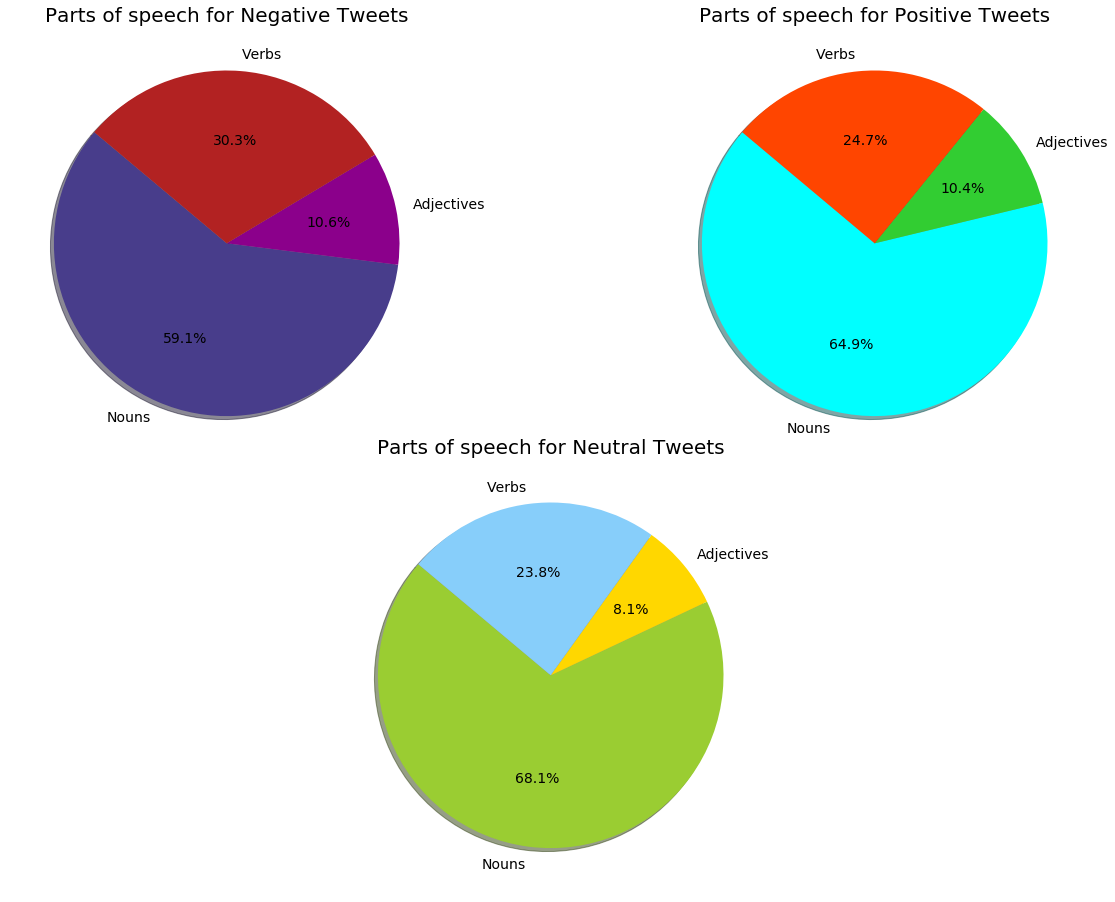

In [56]:
import matplotlib.pyplot as plt

fig=plt.figure()
ax1=fig.add_axes([0,1.5,1.5,1.5],aspect=1)
ax1.set_title("Parts of speech for Negative Tweets").set_fontsize(20)
labels = ['Nouns', 'Adjectives', 'Verbs']
colors = ['DarkSlateBlue', 'DarkMagenta', 'FireBrick']
patches, texts, autotexts=ax1.pie(Negative,labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140,textprops={'fontsize': 14})
ax2=fig.add_axes([1.5,1.5,1.5,1.5],aspect=1)
ax2.set_title("Parts of speech for Positive Tweets").set_fontsize(20)
labels = ['Nouns', 'Adjectives', 'Verbs']
colors = ['Aqua', 'LimeGreen', 'OrangeRed']
patches, texts, autotexts=ax2.pie(Positive,labels=labels, colors=colors,                                
autopct='%1.1f%%', shadow=True, startangle=140,textprops={'fontsize': 14})
ax3=fig.add_axes([0.75,0,1.5,1.5],aspect=1)
ax3.set_title("Parts of speech for Neutral Tweets").set_fontsize(20)
labels = ['Nouns', 'Adjectives', 'Verbs']
colors = ['yellowgreen', 'gold', 'lightskyblue']
patches, texts, autotexts=ax3.pie(Neutral,labels=labels, colors=colors,                                  
autopct='%1.1f%%', shadow=True, startangle=140,textprops={'fontsize': 14})
plt.show()

## <font color=Red> Words used Bar chart </font>

Charts that indicate the most used words for each tweet type

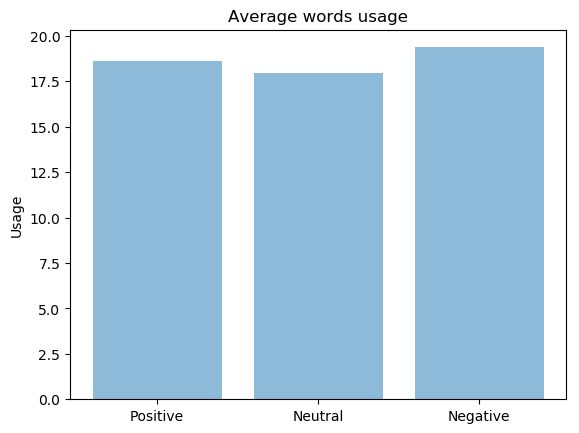

In [60]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('Positive','Neutral','Negative')
y_pos = np.arange(len(objects))

AvWords=[Numberofwords[0]/positiveTweets, Numberofwords[1]/neutralTweets, Numberofwords[2]/negativeTweets ]
plt.bar(y_pos, AvWords, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Average words usage')
 
plt.show()

## <font color=Red> Bar chart that compares part of speach usage </font>

Bar charts that compare the parts of speech usage for each bar chart type

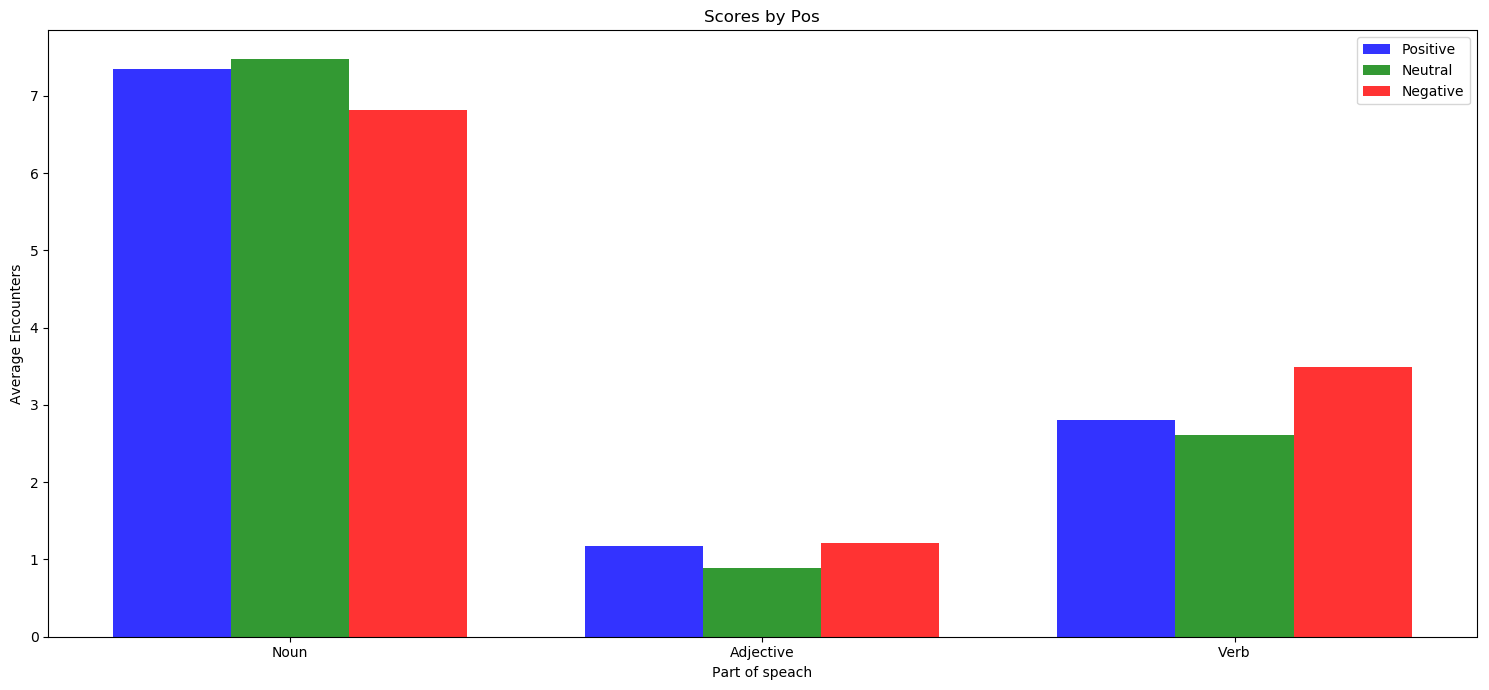

In [67]:
n_groups = 3
means_Pos = [x/positiveTweets for x in Positive]
means_Neg = [x/negativeTweets for x in Negative]
means_Neu = [x/neutralTweets for x in Neutral]
 
# create plot
fig, ax = plt.subplots(figsize=(15,7))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, means_Pos, bar_width,
alpha=opacity,
color='b',
label='Positive')
rects2 = plt.bar(index + bar_width, means_Neu, bar_width,
alpha=opacity,
color='g',
label='Neutral')
rects3 = plt.bar(index + 2*bar_width, means_Neg, bar_width,
alpha=opacity,
color='r',
label='Negative')
 
plt.xlabel('Part of speach')
plt.ylabel('Average Encounters')
plt.title('Scores by Pos')
plt.xticks(index + bar_width, ('Noun', 'Adjective', 'Verb'))
plt.legend()
 
plt.tight_layout()
plt.show()

# <font color=blue>Vectorization & Features Extraction </font>

Combine all the remaining tokens of each tweet as the tweet's text and create a list containing all the tweets'text (each tweet's text is an element of the list). 

In [68]:
def cr_tokList(tweet_info_dic):
    tweetsList=[]
    for tinf in tweet_info_dic.values():
        tweet=" ".join(token for token in tinf[0] )
        tweetsList.append(tweet)
    return tweetsList

tr_tweetsList=cr_tokList(tr_tweet_info)
tst_tweetsList=cr_tokList(tst_tweet_info)

## <font color=red> Bag-of-Words </font>

Create a Bag-of-Words model based on the the tweets of the training set. <br>
Store the training set vectors in a pickle file to load them in the future. <br>
Then vectorize the tweets of the test set based on the created model. <br>
Store the test set vectors in a pickle file to load them in the future.

In [69]:
from sklearn.feature_extraction.text import CountVectorizer 
from pickle import dump

bow_vectorizer = CountVectorizer(max_df=1.0, min_df=1, max_features=7500,stop_words='english') 

def bag_of_words(tweetsList,pkl_file,train):
    if train is True:
        bow_model = bow_vectorizer.fit_transform(tweetsList)
    else:
        bow_model = bow_vectorizer.transform(tweetsList)
        
    with open(pkl_file, 'wb') as handle:
        dump(bow_model, handle)
    return bow_model

tr_bow=bag_of_words(tr_tweetsList,"tr_bow.pkl",True)
tst_bow=bag_of_words(tst_tweetsList,"tst_bow.pkl",False)

Load the Bag-of-Words vectors of the training set tweets from the corresponding pickle file. <br>
Load the Bag-of-Words vectors of the test set tweets from the corresponding pickle file.
## <font color=tomato> CELL 1 </font> 
<a id = 'bow'></a>

In [70]:
from pickle import load

tr_bow = load(open("tr_bow.pkl", "rb" ))
tst_bow = load(open("tst_bow.pkl", "rb" ))

## <font color=red> TF-IDF </font> 

Create a TF-IDF model based on the the tweets of the training set. <br>
Store the training set vectors in a pickle file to load them in the future. <br>
Then vectorize the tweets of the test set based on the created model. <br>
Store the test set vectors in a pickle file to load them in the future.

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from pickle import dump

tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=7500,stop_words='english')

def tf_idf(tweetsList,pkl_file,train):
    if train is True:
        tfidf = tfidf_vectorizer.fit_transform(tweetsList)
    else:
        tfidf = tfidf_vectorizer.transform(tweetsList)

    with open(pkl_file, 'wb') as handle:
        dump(tfidf, handle)

tr_tfidf=tf_idf(tr_tweetsList,"tr_tfidf.pkl",True)
tst_tfidf=tf_idf(tst_tweetsList,"tst_tfidf.pkl",False)

Load the TF-IDF vectors of the training set tweets from the corresponding pickle file. <br>
Load the TF-IDF vectors of the test set tweets from the corresponding pickle file.
## <font color=tomato> CELL 2 </font> 
<a id = 'TF'></a>

In [74]:
from pickle import load

tr_tfidf  = load(open("tr_tfidf.pkl", "rb" ) )
tst_tfidf = load(open("tst_tfidf.pkl", "rb" ) )

## <font color=red> Word Embeddings </font> 

Vectorize each token that exists at least 5 times in the training set tweets using the word to vector method. <br>
Store the vectors in a pickle file to load them in the future.  

In [91]:
from gensim.models import Word2Vec, KeyedVectors   
tweetsTokensLst=[inf[0] for inf in tr_tweet_info.values()]

save_location="model_w2v.bin"
model_w2v = Word2Vec(
            tweetsTokensLst,
            size=300, # desired no. of features/independent variables
            window=3, # context window size
            min_count=5,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 3, # no.of cores
            seed = 34) 

model_w2v.train(tweetsTokensLst, total_examples= len(tweetsTokensLst), epochs=20)

word_vectors_w2v=model_w2v.wv
word_vectors_w2v.init_sims(replace=True)
word_vectors_w2v.save(save_location)
data="trained_given"

Load the word2vec vectors from the corresponding pickle file.

In [92]:
from gensim.models import KeyedVectors

load_location="model_w2v.bin"
word_vectors_w2v = KeyedVectors.load(load_location)
data="trained_given"

Use pretrained word embeddings stored in a glove format file to load the vectors of the tokens of the glove file. <br>
Store the vectors in a pickle file to load them quicker in the future.  <br>
__Note__: You may have to change the path

In [191]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

save_location="pr_model_w2v.bin"
glove_file = datapath("C:\\Users\\User\Desktop\\DM\\pretrained_word_embeddings\\datastories.twitter.300d.txt")
tmp_file = get_tmpfile("C:\\Users\\User\Desktop\\DM\\pretrained_word_embeddings\\datastories.twitter.300d.w2v.txt")

glove2word2vec(glove_file, tmp_file)
word_vectors_w2v = KeyedVectors.load_word2vec_format(tmp_file)
word_vectors_w2v.init_sims(replace=True)
word_vectors_w2v.save_word2vec_format(save_location, binary=True)
data="pretrained_downloaded"

Load the word2vec vectors of the pretrained word embeddings from the corresponding pickle file.

__Note__: You may have to change the path

In [116]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

load_location="C:\\Users\\User\\Desktop\\DM\\scr\\pr_model_w2v.bin"
word_vectors_w2v = KeyedVectors.load_word2vec_format(datapath(load_location), binary=True)
data="pretrained_downloaded"

Create a heat map of 500 random tokens' vectors after transforming them to 2-dimensional vectors using the TSNE method.

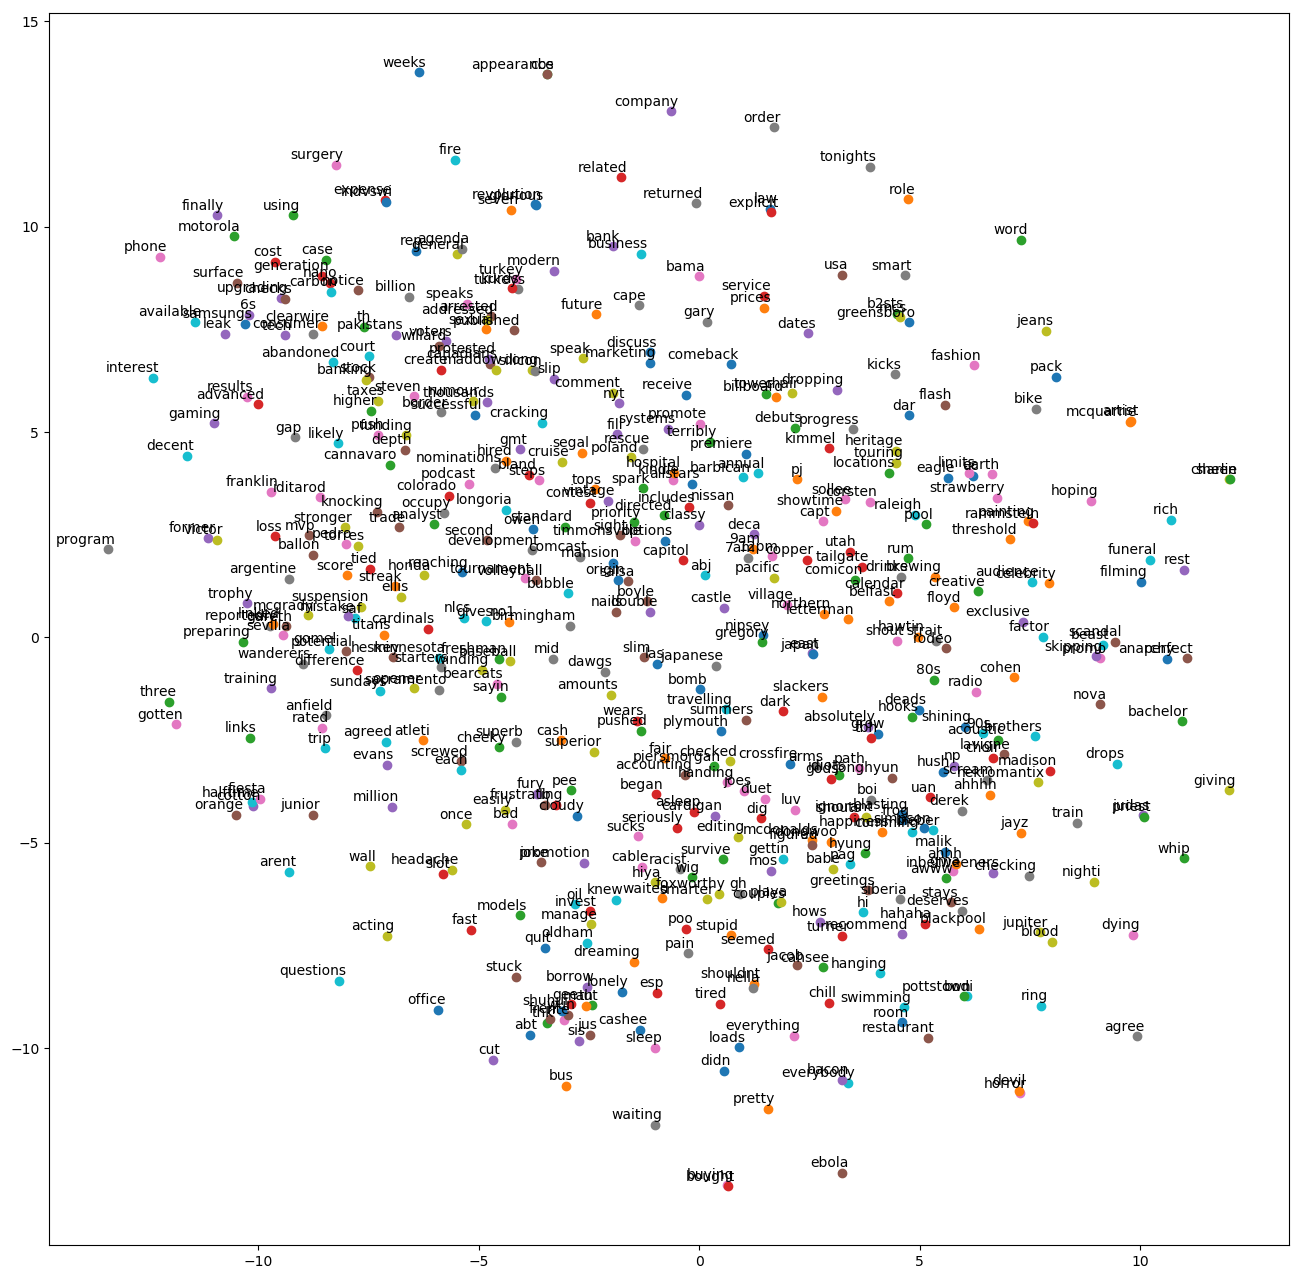

In [93]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from random import sample 

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = sample([k for k in model.vocab.keys()], 500)
    tokens= [word_vectors_w2v.__getitem__(l) for l in labels]
        
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []

    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points', ha='right', va='bottom')
    plt.show();

tsne_plot(word_vectors_w2v)

Given the tweet's list of tokens, computate the tweet's vector.
If the tweet's list of tokens is empty (due to data cleaning), a random normalized vector is selected.
If a token's vector has't been computated (since it appears less than 5 times in the training set tweets), a random vector is selected for that token taking into account the computated token's vectors,so that our data aren't corrupted.

In [94]:
from random import uniform

def text2vec(tokenized_text):
    
    if tokenized_text==[]:
        return [uniform(-1, 1) for d in range(word_vectors_w2v.vector_size)]
    
    text_vec=[0 for d in range(word_vectors_w2v.vector_size)]
    notFound=0
    found=0
    max_vals=[-1 for d in range(word_vectors_w2v.vector_size)]
    min_vals=[1 for d in range(word_vectors_w2v.vector_size)]
    
    for token in tokenized_text:
        if token in word_vectors_w2v:
            for i in range(word_vectors_w2v.vector_size):
                tok_vec=list(word_vectors_w2v.__getitem__(token))
                text_vec[i]+=tok_vec[i]
                if max_vals[i]<tok_vec[i]:
                    max_vals[i]=tok_vec[i]
                elif min_vals[i]>tok_vec[i]:
                    min_vals[i]=tok_vec[i]
            found+=1    
        else:
            notFound+=1
    if found==0:
        return [uniform(-1, 1) for d in range(word_vectors_w2v.vector_size)]
    else:
        tok_vec=[notFound*uniform(min_vals[i], max_vals[i]) for i in range(word_vectors_w2v.vector_size)]
        for i in range(word_vectors_w2v.vector_size):
            text_vec[i]+=tok_vec[i]
                
        for i in range(word_vectors_w2v.vector_size):
            text_vec[i]=text_vec[i]/float(found)
        return text_vec

Vectorize the tweets of the training set using the word embedding method. <br>
Store the vectors in a pickle file to load them in the future. <br>
Repeat the process for the tweets of the test set. <br>

For each of the downloaded tokens' vectors and our trained vectors 2 pickle files are used.

In [117]:
tweet_maxLength=0

def word_embedding(tokens_dic):
    global tweet_maxLength
    word_emb={}
    for tweet_id, tweet_info in tokens_dic.items():
        tokenized_text=tweet_info[0]
        tweet_length=tweet_info[4]
        if tweet_length>tweet_maxLength:
            tweet_maxLength=tweet_length
        t_vector=text2vec(tokenized_text)
        word_emb[tweet_id]=t_vector
    return word_emb

if data=="pretrained_downloaded" or data=="trained_given":
    if data=="pretrained_downloaded":
        picklefiles=["train_prd_wmb.pkl", "test_prd_wmb.pkl"]
    else:
        picklefiles=["train_trd_wmb.pkl","test_trd_wmb.pkl"]

tst_wemb=word_embedding(tst_tweet_info)   
tr_wemb=word_embedding(tr_tweet_info)

with open(picklefiles[0], 'wb') as handle:
    dump(tr_wemb, handle)
                     
with open(picklefiles[1], 'wb') as handle:
    dump(tst_wemb, handle)

Load the word embeddings pretrained downloaded vectors of the training set tweets from the corresponding pickle file. <br>
Load the word embeddings pretrained downloaded vectors of the test set tweets from the corresponding pickle file.
## <font color=tomato> CELL 3 </font> 
<a id = 'WordEmb'></a>

In [197]:
from pickle import load

data="pretrained_downloaded"
tr_wemb  = load(open("train_prd_wmb.pkl", "rb" ) )
tst_wemb = load(open("test_prd_wmb.pkl", "rb" ) )

Load the word embeddings trained vectors of the training set tweets from the corresponding pickle file. <br>
Load the word embeddings trained vectors of the test set tweets from the corresponding pickle file.
## <font color=tomato> CELL 4 </font> 
<a id = 'WordEmb2'></a>

In [202]:
from pickle import load

data="trained_given"
tr_wemb  = load(open("train_trd_wmb.pkl", "rb" ) )
tst_wemb = load(open("test_trd_wmb.pkl", "rb" ) )

## <font color=red> Word Embeddings with additional features </font> 

Add to the word embedings vectors: <br>
>one feature for each lexicon considering the mean value of the tweet's tokens (after the tweet is cleaned) in the lexicon. <br>
>one feature taking the tweet's length (before the tweet is cleaned) into account <br>
>one feature for each of the percentages of verbs,nouns and adjectives existing in the tweet (before the tweet is cleaned).

The vector remains normalized, as for each feature xi of the vector -1 $\le$ xi $\le$ 1

In [119]:
def add_features(tokens_dic,wemb_dic):
    global tweet_maxLength
    word_emb_extra_chs={}
    for tweet_id, tweet_info in tokens_dic.items():
        nouns,adjs,vbs,tweet_length,tweet_mvals=tweet_info[1:6]
        word_emb_extra_chs[tweet_id]=wemb_dic[tweet_id]+tweet_mvals+[float(tweet_length)/tweet_maxLength, vbs/float(tweet_length), adjs/float(tweet_length), nouns/float(tweet_length)]
    return word_emb_extra_chs
    
if data=="pretrained_downloaded" or data=="trained_given":
    if data=="pretrained_downloaded":
        picklefiles=["train_prd_wmb_extra.pkl", "test_prd_wmb_extra.pkl"]
    else:
        picklefiles=["train_trd_wmb_extra.pkl","test_trd_wmb_extra.pkl"]    

tst_wemb_extra=add_features(tst_tweet_info,tst_wemb)   
tr_wemb_extra=add_features(tr_tweet_info,tr_wemb)

with open(picklefiles[0], 'wb') as handle:
    dump(tr_wemb_extra, handle)
                     
with open(picklefiles[1], 'wb') as handle:
    dump(tst_wemb_extra, handle)

Load the word embeddings pretrained downloaded vectors with added features of the training set tweets from the corresponding pickle file. <br>
Load the word embeddings pretrained downloaded vectors with added features of the test set tweets from the corresponding pickle file.
## <font color=tomato> CELL 5 </font> 
<a id = 'WordEmbExtra'></a>

In [207]:
from pickle import load

data="pretrained_downloaded"
tr_wemb_extra  = load(open("train_prd_wmb_extra.pkl", "rb" ) )
tst_wemb_extra = load(open("test_prd_wmb_extra.pkl", "rb" ) )

Load the word embeddings trained vectors with added features of the training set tweets from the corresponding pickle file. <br>
Load the word embeddings trained vectors  with added features of the test set tweets from the corresponding pickle file.
## <font color=tomato> CELL 6 </font> 
<a id = 'WordEmbExtra2'></a>

In [40]:
from pickle import load

data="trained_given"
tr_wemb_extra  = load(open("train_trd_wmb_extra.pkl", "rb" ) )
tst_wemb_extra = load(open("test_trd_wmb_extra.pkl", "rb" ) )

# <font color=blue>Classification </font>

## <font color=red> SVM for Bag of Words </font> 

To enter this stage make sure you have [CELL 1](#bow) compiled
Follows an example of the split and test usage , ill  see if i will implement it to our final svm that follows  bellow.

In [71]:
from sklearn import svm
from sklearn import metrics

We use tr_bow , which is the vectorized training tweets list along with the correct labels to train our data.Then on our trained model we insert the vectorized test tweets and see what we found

In [190]:
svc = svm.SVC(kernel='linear', C=0.5 , class_weight='balanced', probability=True) #initiallizing the svc
svc = svc.fit(tr_bow, individs) # Giving a two dimensional vector array along with the sentiments
prediction = svc.predict(tst_bow) #predict on the validation set
metrics.accuracy_score(glab_df["Sentiment"], prediction) #find the success score

0.5242591989579941

## <font color=red> SVM for TF-IDF </font> 
To enter this stage make sure you have [CELL 2](#TF) compiled

In [44]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

The same procedure as in the Bag of Words but with tf idf method

In [196]:
svc = svm.SVC(kernel='linear', C=1.5, class_weight='balanced', probability=True)#initiallizing the svc
svc = svc.fit(tr_tfidf, individs) # Giving a two dimensional vector array along with the sentiments
prediction = svc.predict(tst_tfidf)  #predict on the validation set
metrics.accuracy_score(glab_df["Sentiment"], prediction) #find the success score

0.5194562031911429

## <font color=red> SVM for Word Embedings </font> 
To enter this stage make sure you have [CELL 3](#WordEmb) (for the pretrained models) or [CELL 4](#WordEmb2) (for the trained from us models) compiled

Initially we have a dictionary each tweet id as key and value , a vector of size 1 x c , where c are the characteristics.
We give to the fit function a list containing the vectors of the train set. Likewise, we give to the predict function a list containing the vectors of the test set.

In [203]:
from sklearn import svm
from sklearn import metrics
import statistics
svc = svm.SVC(kernel='linear', C=1, class_weight='balanced', probability=True)
stats=[]
for key in tr_wemb:#Translating the dictionary into a list
    stats.append(tr_wemb[key])

In [204]:
svc = svc.fit(stats, individs) #Giving a 2 dimensional array/list 

In [205]:
stats2=[]#making the list out of the test
for key in tst_wemb:
    stats2.append(tst_wemb[key])
prediction = svc.predict(stats2) #predict on the validation set
if data=="trained_given":
    trained_score=metrics.accuracy_score(glab_df["Sentiment"], prediction) #find the success score
else:
    pretrained_score=metrics.accuracy_score(glab_df["Sentiment"], prediction) #find the success score

In [206]:
trained_score

0.45050472158905897

In [201]:
pretrained_score

0.5674047541517421

## <font color=red> SVM for Word Embedings with added features </font> 
To enter this stage make sure you have [CELL 5](#WordEmbExtra) (for the pretrained models) or [CELL 6](#WordEmbExtra2) (for the trained from us models) compiled. <br>
The same procedure as above is followed.

In [41]:
from sklearn import svm
from sklearn.metrics import f1_score
import statistics
svc = svm.SVC(kernel='linear', C=1, probability=True)
stats=[]
for key in tr_wemb_extra:#Translating the dictionary into a list
    stats.append(tr_wemb_extra[key])

In [42]:
svc = svc.fit(stats, individs) #Giving a 2 dimensional array/list 

In [45]:
stats2=[]#making the list out of the test
for key in tst_wemb_extra:
    stats2.append(tst_wemb_extra[key])
prediction = svc.predict(stats2) #predict on the validation set
if data=="trained_given":
    trained_extra_score=metrics.accuracy_score(glab_df["Sentiment"], prediction) #find the success score
else:
    pretrained_extra_score=metrics.accuracy_score(glab_df["Sentiment"], prediction) #find the success score

In [46]:
trained_extra_score

0.5465646369260827

In [211]:
pretrained_extra_score

0.5982578964506675

## <font color=red> KNN for BOW </font> 
To enter this stage make sure you have [CELL 1](#bow) compiled

In [147]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [148]:
knn = KNeighborsClassifier(n_neighbors=100)

In [149]:
knn.fit(tr_bow, individs)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=100, p=2,
           weights='uniform')

In [150]:
pre=knn.predict(tst_bow)

In [152]:
print(metrics.accuracy_score(glab_df["Sentiment"], pre))

0.4839628785411918


## <font color=red> KNN for TF-IDF </font> 
To enter this stage make sure you have [CELL 2](#TF) compiled

In [153]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [154]:
knn = KNeighborsClassifier(n_neighbors=100)

In [155]:
knn.fit(tr_tfidf, individs)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=100, p=2,
           weights='uniform')

In [156]:
pre=knn.predict(tst_tfidf)

In [157]:
print(metrics.accuracy_score(glab_df["Sentiment"], pre))

0.4832302181699772


## <font color=red> KNN for Word Embedings</font> 
To enter this stage make sure you have [CELL 3](#WordEmb) (for the pretrained models) or [CELL 4](#WordEmb2) (for the trained from us models) compiled

In [169]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [170]:
knn = KNeighborsClassifier(n_neighbors=100)

In [171]:
stats=[]
for key in tr_wemb:
    stats.append(tr_wemb[key])
knn.fit(stats, individs)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=100, p=2,
           weights='uniform')

In [172]:
stats2=[]
for key in tst_wemb:
    stats2.append(tst_wemb[key])
pre=knn.predict(stats2)
if data=="trained_given":
    trained_score=metrics.accuracy_score(glab_df["Sentiment"], pre)
else:
    pretrained_score=metrics.accuracy_score(glab_df["Sentiment"], pre)

In [167]:
trained_score

0.4921849560403777

In [173]:
pretrained_score

0.5654509931618366

## <font color=red> KNN for Word Embedings with with added features</font> 
To enter this stage make sure you have [CELL 5](#WordEmbExtra) (for the pretrained models) or [CELL 6](#WordEmbExtra2) (for the trained from us models) compiled

In [185]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [186]:
knn = KNeighborsClassifier(n_neighbors=100)

In [187]:
stats=[]
for key in tr_wemb_extra:
    stats.append(tr_wemb_extra[key])
knn.fit(stats, individs)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=100, p=2,
           weights='uniform')

In [188]:
stats2=[]
for key in tst_wemb_extra:
    stats2.append(tst_wemb_extra[key])
pre=knn.predict(stats2)
if data=="trained_given":
    trained_extra_score=metrics.accuracy_score(glab_df["Sentiment"], pre)
else:
    pretrained_extra_score=metrics.accuracy_score(glab_df["Sentiment"], pre)

In [183]:
trained_extra_score

0.5516118528166721

In [189]:
pretrained_extra_score

0.6005372842722241

## <font color=Turquoise> Presentation of our findings and commenting on our findings</font> 

In [16]:
df=pd.DataFrame(columns=['SVM','KNN'],index=['BoW','TF-IDF','WordEmbedingsTrained','WordEmbedingsPretrained','WordEmbedingsTrained(extra features)','WordEmbedingsPretrained(extra features)'])

In [47]:
df['SVM']=[0.5242,0.5194,0.4505,0.5674,0.5465,0.5982]
df['KNN']=[0.4839,0.4832,0.4921,0.5654,0.5516,0.6005]
df

,SVM,KNN
BoW,0.5242,0.4839
TF-IDF,0.5194,0.4832
WordEmbedingsTrained,0.4505,0.4921
WordEmbedingsPretrained,0.5674,0.5654
WordEmbedingsTrained(extra features),0.5465,0.5516
WordEmbedingsPretrained(extra features),0.5982,0.6005


Bag-of-Words and TF-IDF models perform better when the SVM classifier is used instead  of the KNN classifier. The results of the these 2 vectorization methods are similiar for the same classification technique. This may be due to the fact that our data are cleaned beforehand.

Our word embedding model doesn't perform as good as the previous ones when the SVM classifier is used. Instead, for the KNN classifier the accuracy of the model is slightly better than the accuracy of BoW and TF-IDF models.

Adding features to the word embedding vectors results in increased accuracy for both classifiers. Using this method we achieve our best accuracy scores. 

The results of the pretrained word embedding model are better than the results of our word embedding model for both classifiers and regardless from whether we have added extra features. This is due to the fact that the pretrained data were obtained using a larger pool of data for training.